In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Import Required Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Flatten, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Load the Dataset

In [3]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
print('Train data size:', train_data.shape)
print('Test data size:', test_data.shape)

Train data size: (42000, 785)
Test data size: (28000, 784)


# Display the First Few Rows of Training and Test Data

In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#  Data Exploration

In [6]:
# Check for duplicate images
duplicates = train_data.duplicated(subset=train_data.columns[1:])
print(f'Number of duplicate images: {duplicates.sum()}')


Number of duplicate images: 0


In [7]:
# Count occurrences of each digit
label_counts = train_data['label'].value_counts().sort_index()
print(label_counts)

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64


## Visualize the Distribution of Classes

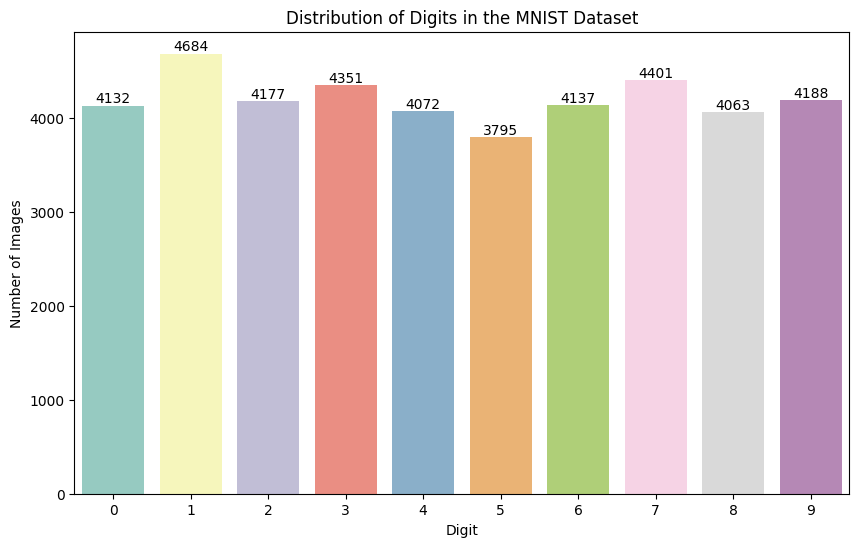

In [8]:
# Create a DataFrame for plotting
data = pd.DataFrame({
    'Class Name': label_counts.index,
    'Count': label_counts.values
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Class Name', y='Count', data=data, palette="Set3")
plt.title('Distribution of Digits in the MNIST Dataset')
plt.xlabel('Digit')
plt.ylabel('Number of Images')

for i in data.index:
    plt.text(i, data['Count'][i], str(data['Count'][i]), ha='center', va='bottom')

plt.show()

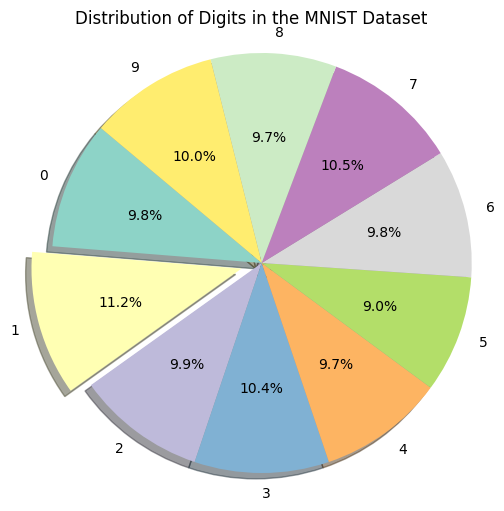

In [9]:
# Labels for the sections of our pie chart
labels = label_counts.index

# The values are the counts of each class
sizes = label_counts.values

colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
explode = [0.1 if i == max(sizes) else 0 for i in sizes]
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Digits in the MNIST Dataset')
plt.show()

## Visualizing Sample Images

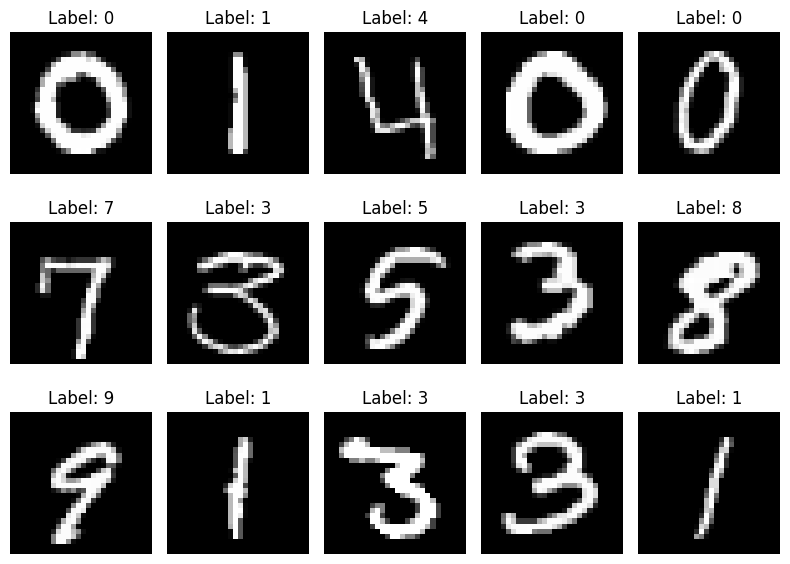

In [10]:
# Plot some sample digits
plt.figure(figsize=(8, 6))
for i in range(1, 16):
    plt.subplot(3, 5, i)
    img = train_data.iloc[i, 1:].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {train_data.iloc[i, 0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Visualize Mean Pixel Values for Each Digit

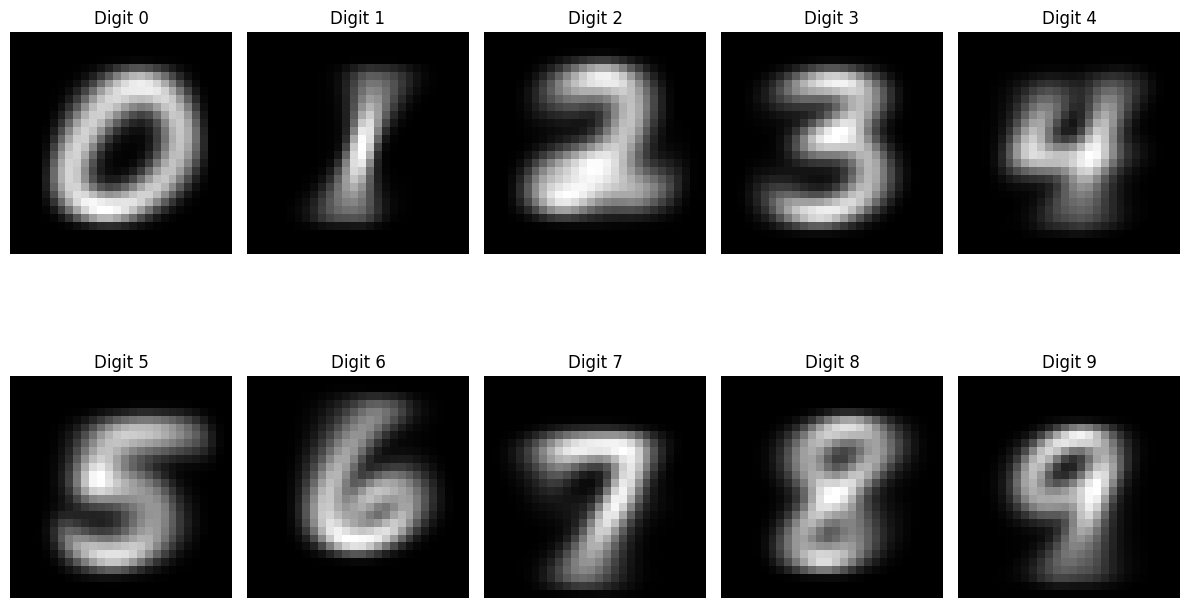

In [11]:
# Compute mean pixel values for each digit
mean_pixel_values = train_data.groupby('label').mean()

# Plot heatmaps to visualize the average pixel intensity for each digit
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mean_pixel_values.loc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f'Digit {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [12]:
# Separate the labels and normalize pixel values
X = train_data.drop('label', axis=1) / 255.0
y = train_data['label']
X_test = test_data / 255.0

In [13]:
# Reshape the data into 28x28 pixel images with 1 channel (grayscale)
X = X.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

# Split the Data into Training and Validation Sets

In [14]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

print('Training data shape:', X_train.shape)
print('Validation data shape:', X_val.shape)
print('Test data shape:', X_test.shape)

Training data shape: (33600, 28, 28, 1)
Validation data shape: (8400, 28, 28, 1)
Test data shape: (28000, 28, 28, 1)


# Build the CNN Model

In [15]:
# Build a CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    # Second convolutional block
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    # Third convolutional block
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    # Fourth convolutional block
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    
    # Global average pooling
    GlobalAveragePooling2D(),
    
    # Dense layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(10, activation='softmax')
])

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Using a lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,154 (664.66 KB)

 Trainable params: 169,642 (662.66 KB)

 Non-trainable params: 512 (2.00 KB)

# Data Augmentation and Training

In [17]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,       # Rotate images by 10 degrees
    width_shift_range=0.1,   # Shift images horizontally by 10%
    height_shift_range=0.1,  # Shift images vertically by 10%
    zoom_range=0.1           # Zoom into images by up to 10%
)

# Fit the data generator on the training data
datagen.fit(X_train)

In [18]:
# Train the model using the data generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), 
                    validation_data=(X_val, y_val), 
                    epochs=20)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.3678 - loss: 1.9679 - val_accuracy: 0.5230 - val_loss: 1.4063
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.8927 - loss: 0.5419 - val_accuracy: 0.9636 - val_loss: 0.2746
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.9450 - loss: 0.3504 - val_accuracy: 0.9676 - val_loss: 0.2494
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.9571 - loss: 0.3030 - val_accuracy: 0.9758 - val_loss: 0.2189
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.9660 - loss: 0.2643 - val_accuracy: 0.9799 - val_loss: 0.2013
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.9686 - loss: 0.2537 - val_accuracy: 0.9829 - val_loss: 0.1878
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.9738 - loss: 0.2302 - val_accuracy: 0.9860 - val_loss: 0.1788
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.9765 - loss: 0.2159 - 

In [19]:
# Train the model
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=64)


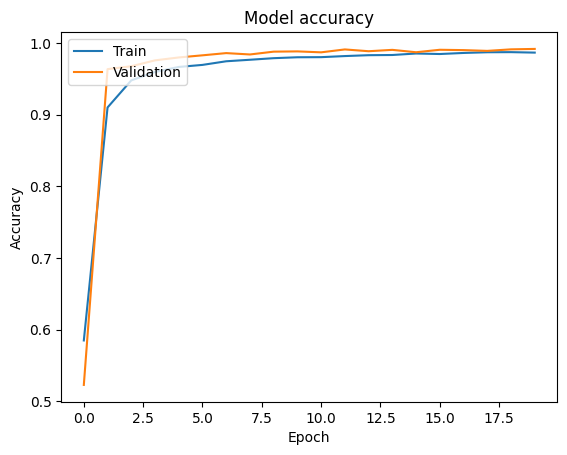

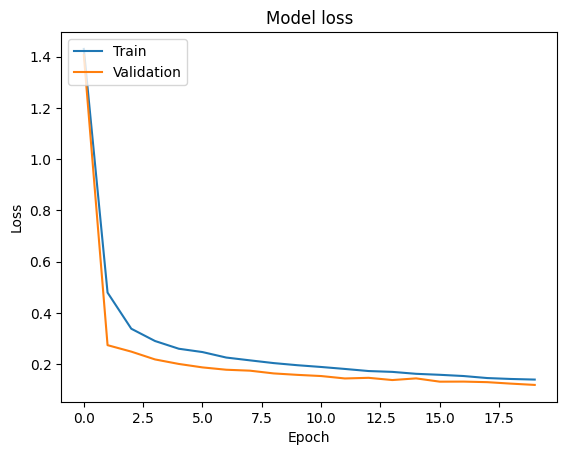

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the Model on Validation Set

In [21]:
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


# Plot the Confusion Matrix

In [22]:
# Print a classification report
report = classification_report(y_val, y_pred_classes)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       785
           1       1.00      0.99      1.00       949
           2       0.99      1.00      0.99       838
           3       1.00      1.00      1.00       858
           4       0.98      1.00      0.99       796
           5       0.99      0.99      0.99       800
           6       0.99      0.99      0.99       870
           7       0.99      0.99      0.99       860
           8       0.99      0.99      0.99       817
           9       1.00      0.98      0.99       827

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



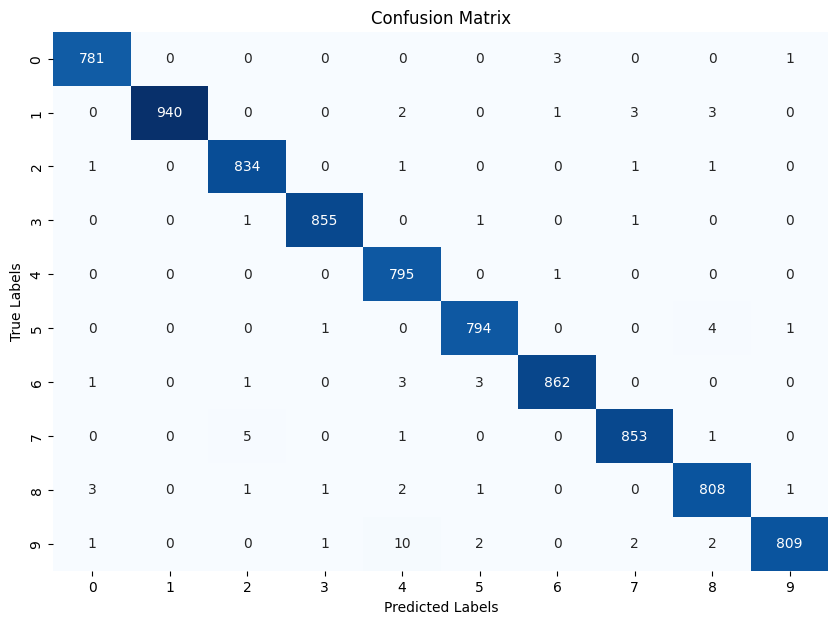

In [23]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Predict on the Test Set and Prepare Submission

In [24]:
# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare the submission file
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(predicted_labels) + 1),
    'Label': predicted_labels
})

submission.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")

875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
Your submission was successfully saved!


### Displaying Validation Set Images with True and Predicted Labels

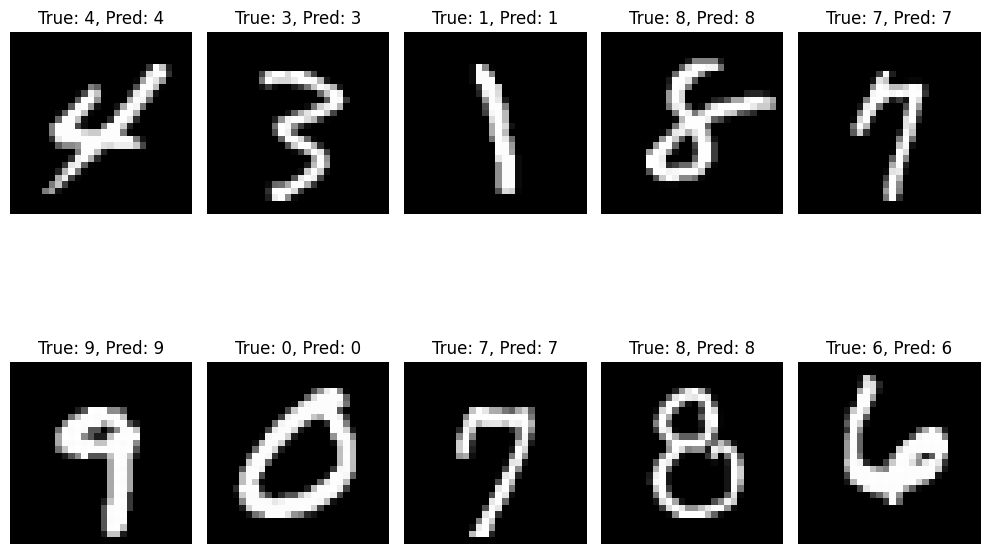

In [25]:
# Select a few images from the validation set to display
num_images = 10
random_indices = np.random.choice(len(X_val), num_images, replace=False)
X_sample = X_val[random_indices]
y_true_sample = y_val.iloc[random_indices]
y_pred_sample = y_pred_classes[random_indices]

# Plot the images along with their predicted and true labels
plt.figure(figsize=(10, 8))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_sample[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_true_sample.iloc[i]}, Pred: {y_pred_sample[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Displaying Test Set Images with Predicted Labels Only

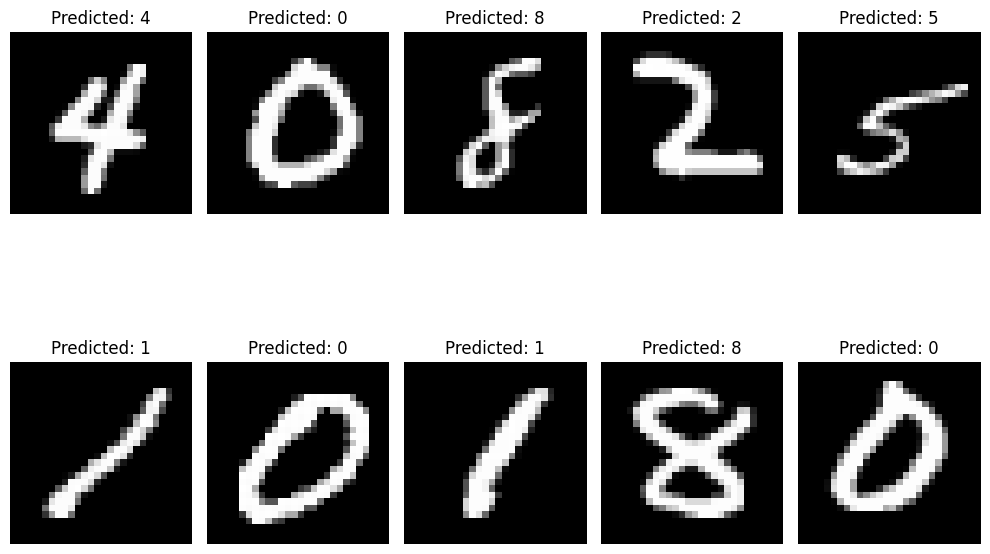

In [26]:
# Plot the test images with predicted labels
num_images = 10
plt.figure(figsize=(10, 8))

for i in range(num_images):
    # Select a random index from the test set
    index = np.random.randint(0, len(X_test))
    
    # Get the image and predicted label
    img = X_test[index].reshape(28, 28)  # Reshape the image to 28x28
    predicted_label = predicted_labels[index]  # Get the predicted label for the image
    
    # Plot the image
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
